In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.draw import draw_digits
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [3]:
digits = datasets.MNIST('data', download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: 
                                              torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                        ])
                     )

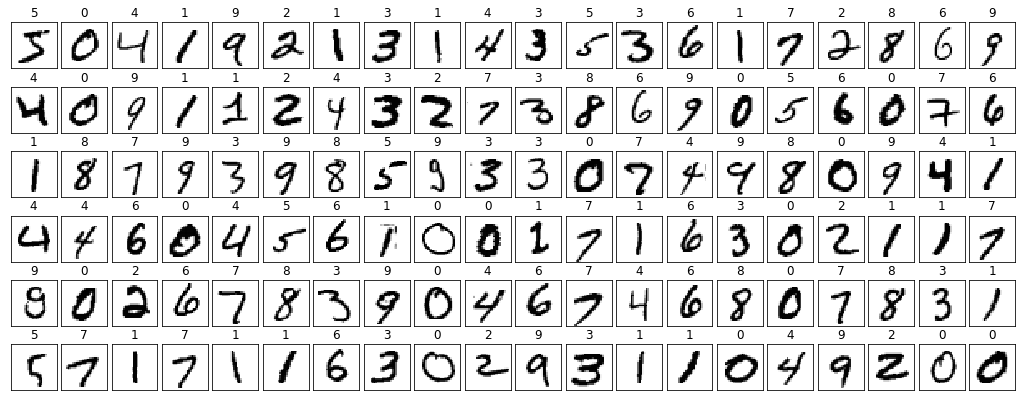

In [4]:
draw_digits(digits)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the nn package to define our model and loss function.
model = CNN()
model = model.to(device)

cost = torch.nn.BCELoss()

# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, 3)

# dataset!
dataloader = DataLoader(digits, batch_size=64, num_workers=0, pin_memory=True)

epochs = 10

In [7]:
for t in range(epochs):
    print('\nepoch {}, (lr: {:>.1e})'.format(t, scheduler.get_last_lr()[0]))
    print('-------------------------------')
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print('loss: {:>10f}  [{:>5d}/{:>5d}]'.format(loss.item(), batch * len(X), len(dataloader.dataset)))
            
    # step scheduler
    scheduler.step()


epoch 0, (lr: 1.0e-03)
-------------------------------
loss:   0.325435  [    0/60000]
loss:   0.141028  [ 6400/60000]
loss:   0.092830  [12800/60000]
loss:   0.084161  [19200/60000]
loss:   0.069875  [25600/60000]
loss:   0.077485  [32000/60000]
loss:   0.045714  [38400/60000]
loss:   0.071020  [44800/60000]
loss:   0.078321  [51200/60000]
loss:   0.096473  [57600/60000]

epoch 1, (lr: 1.0e-03)
-------------------------------
loss:   0.044585  [    0/60000]
loss:   0.033604  [ 6400/60000]
loss:   0.036741  [12800/60000]
loss:   0.258524  [19200/60000]
loss:   0.044610  [25600/60000]
loss:   0.054129  [32000/60000]
loss:   0.035628  [38400/60000]
loss:   0.049562  [44800/60000]
loss:   0.100081  [51200/60000]
loss:   0.093859  [57600/60000]

epoch 2, (lr: 1.0e-03)
-------------------------------
loss:   0.033547  [    0/60000]
loss:   0.027782  [ 6400/60000]
loss:   0.052631  [12800/60000]
loss:   0.041481  [19200/60000]
loss:   0.019959  [25600/60000]
loss:   0.043494  [32000/60000]


# Does it work???

In [8]:
test_data = datasets.MNIST('data', train=False, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: 
                                              torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                        ])
                     )
test_loader = DataLoader(digits, batch_size=64, num_workers=0, pin_memory=True)

In [9]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for batch, (X, Y) in enumerate(test_loader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        test_loss += cost(pred, Y).item()
        correct += (pred.argmax(1) == Y.argmax(1)).type(torch.float).sum().item()

test_loss /= len(dataloader.dataset)
correct /= len(dataloader.dataset)
print('Test Error:')
print('acc: {:>0.1f}%, avg loss: {:>8f}'.format(100*correct, test_loss))

Test Error:
acc: 97.8%, avg loss: 0.000202


In [10]:
len(test_data)

10000

# Saving Things!

In [11]:
import torch.onnx as onnx

# create dummy variable to traverse graph
x = torch.randint(255, (1, 28*28), dtype=torch.float).to(device) / 255
onnx.export(model, x, 'superfile.onnx')
print('Saved onnx model to "superfile.onnx"')

Saved onnx model to "superfile.onnx"
